### <span style="color:blue"> ***Score: 95*** </span>

### <span style="color:blue"> Questions 1: -5 pts </span>

<span style="color:blue"> 
Main comments: All time complexity estimations are in big $\mathcal{O}$, i.e. there are constants in front of all costs, so you cannot simply sum them up.
</span>

### Problem 1, please work out the time complexity of computing a naive K-Fold Cross Validation Ridge Regression on an N × F input matrix

* We first evaluate the time complexity for ridge regression.



\begin{equation}
\hat\beta = (X^T X + \lambda I)^ {-1} X^TY
\end{equation}

And the time complexity in big **O( )** notation will be the maximum of the time complexity of these operations. 

| Operation | time complexity |
|---------------|-|
| $X^T X$ |   $NF^2$    |
| $X^T X +\lambda I$|   $F$     |
| $(X^T X + \lambda I)^ {-1}$|   $F^3$     |
|$(X^T X + \lambda I)^ {-1} X^T$|$F^2N$|
| $(X^T X + \lambda I)^ {-1} X^TY$|$NF$|

So the time complexity if **$\left({O(F^2(F+N)}\right)$**

* When using K-Fold Cross Validation Ridge Regression, we do ridge regression for K times. We repeat ridge regression K times for each $\lambda$.The number of samples will be shrinked to  $\frac{(K-1)}{K} N$. However, these factors are constant when we only consider the matrix dimentions. So, the time complexity is  **$\left({O(F^2(F+N)}\right)$**
* Take K into considerations, we will have the time complexity as **$\left({O(KF^2(F+N)}\right)$**

### Problem 2 write a description  of how you can efficiently compute X −i X −i for all K folds.

* first, we devide X into K blcok
$$
X = \left[
    \begin{matrix}
     X_1 \\ X_2 \\ ... \\ X_k 
    \end{matrix}
    \right]
$$

and then we comput $X_k^T \, X_k$ by doing dot mltiplication one by one.



* Second, suming up these matrixs we have
$$
X^T X 
       =\sum \left[
        \begin{matrix}
        X_1^T \, X_1 + X_2^T \, X_2 + ... + X_k^T \, X_k 
        \end{matrix}
        \right] 
$$




* Finally, we  compute 
$X_{-i}^T \, X_{-i} = XTX - X_i^T \, X_i$


In [1]:
import numpy as np
import time 
import matplotlib.pyplot as plt
import timeit

In [167]:
def generate_test_data(n ,f ):
    """
    Given from assignment
    """
    np.random.seed( 1 )
    truebetas = np.random.randn(f )
    X = np.random.randn( n , f )
    Y = np.random.randn( n ) + X.dot(truebetas)
    return (X,Y)

def pre_process(X,Y,num_folds):
    """
    commend in the line with *** to random shuffle data before CV
    randomly shuffle X and Y correspondly
    return shuffled X,y and k folds of Xk's and Yk's
    """
    
    #*****shuffle_seed = 1
    
    #*****np.random.seed(shuffle_seed )
    #*****np.random.shuffle(X)
    x_blocks = np.split(X,num_folds)
    
    #keep shuffled data in order
    #*****np.random.seed(shuffle_seed )
    #*****np.random.shuffle(Y)
    y_blocks = np.split(Y,num_folds)
    
    #get the training sets in CV
  
    
    """
    ********************************************************************
    By caching the train sets, we can really speed up for both
    for N = 1000,000 F = 50, K = 10,num_lambdas = 5
    Naive took 11.3 seconds
    Quick version took 2.36 seconds
    However, this will result in memory error in PC with small memory.
    *********************************************************************
    
    for j in range(num_folds):
        x_train.append(np.vstack([fold for index,fold in enumerate(x_blocks) if index != j]))
        y_train.append(np.concatenate([fold for index,fold in enumerate(y_blocks) if index != j ]))
     
    """
    return X,Y,x_blocks,y_blocks
       
def _solve_lineareq(X,y,alambdas):
    """
    solve the linear equation with X,Y and the lambda for naive ridge regression
    beta_hat = (XTX+lambdaI)^(-1)XTY
    """
    n_samples,n_features = X.shape
    A = np.dot(X.T,X)
    Xy= np.dot(X.T,y)
  
    A.flat[::n_features+1] += alambdas
    

    return np.linalg.solve(A, Xy)

def fast_solve_lineareq(XTX_i,X,y,alambdas):
    """
    The fast version for solving linear equation
    """
    n_samples,n_features = X.shape
    # A is the precomputed matirx
    A = XTX_i
    #X is Xk
    Xy= np.dot(X.T,y) 
    
   
    A.flat[::n_features+1] += alambdas

    return np.linalg.solve(A, Xy)

def calculate_mse(x_validate,y_validate,coef):
    """
    calculate the mse using one fold and the calculated coef
    """    
    y_predict = np.dot(x_validate,coef)
    
    return (np.linalg.norm(-y_validate + y_predict))
    
def sub_matrix_multi(x_blocks,num_folds):
    """
    given a list of matrixs Xk, return a list of XkTXk
    """
    return [i.T.dot(i) for i in x_blocks] 



def naive_ridge_cv(X,Y,num_folds,lambdas):
    ''' 
    Implements a naive (ie slow) Ridge Regression of X against Y. 
    It will take in a list of suggested lambda values and 
    return back the lambda and betas that generates minimum mean squared error .

    Parameters
    −−−−−−−−−−
        X : numpy ndarray
            The independent variables, structured as (samples x features)
        Y : numpy ndarray
            The dependent variable , (samples x 1)
        num_folds : int
            The number of folds to use for cross validation, has to be greater than 1
        lambdas : numpy ndarray
            An array of lambda values to test

    Returns
    −−−−−−−
        lambda_star : float
            The lambda value that represents the min MSE
        beta_star : numpy ndarray The optimal betas
    '''
    n_lambdas,n_feature = len(lambdas),X.shape[1]
    X,Y,x_blocks,y_blocks= pre_process(X,Y,num_folds)
    
    #an array to store the best 
    lambda_star,smallest_err =0,float("inf")
        
    for i in lambdas:
        #record the error for current lambda
        cur_error = 0
        
        for j in range(num_folds):
            x_train = (np.vstack([fold for index,fold in enumerate(x_blocks) if index != j]))
            y_train = (np.concatenate([fold for index,fold in enumerate(y_blocks) if index != j ]))
    
            
  
            #set the test set
            x_validate = x_blocks[j]
            y_validate = y_blocks[j]
            # solve the equation
            coef = _solve_lineareq(x_train,y_train,i)
            # accumulate the mse
            cur_error += calculate_mse(x_validate,y_validate,coef)
        #compare mse's between lambdas
       
        if cur_error < smallest_err:
            lambda_star,smallest_err = i,cur_error
    #return the best lambdas, and the betas based on that lambda        
    return lambda_star,_solve_lineareq(X,Y,lambda_star)
            
def fast_ridge_cv(X,Y,num_folds,lambdas):
 
  
    n_lambdas,n_feature = len(lambdas),X.shape[1] 
    X,Y,x_blocks,y_blocks= pre_process(X,Y,num_folds)
    
    
    lambda_star,smallest_err = 0,float("inf")
    
    #calcualte a list of XkTXk
    Xk_blocks = sub_matrix_multi(x_blocks,num_folds)
    #calculate XTX
    XTX = sum(Xk_blocks)
    
    
   
    
    for i in lambdas:
        cur_error = 0
        """
        **********************************
        if I pre-calculate XTX_i before the loop, it will have an error at the 7 digits at the diagnal of XTX_i
        as loop grows. Why is that?
        **********************************
        """
        #Calculate XTX-X_iTX_i
        XTX_i = [XTX - Xk for Xk in  Xk_blocks]
          
        for j in range(num_folds):
            
            x_train =(np.vstack([fold for index,fold in enumerate(x_blocks) if index != j]))
            y_train =(np.concatenate([fold for index,fold in enumerate(y_blocks) if index != j ]))
    
            
            x_validate = x_blocks[j]
            y_validate = y_blocks[j]
            coef = fast_solve_lineareq(XTX_i[j],x_train,y_train,i)
            cur_error += calculate_mse(x_validate,y_validate,coef)
        
        if cur_error < smallest_err:
           
            lambda_star,smallest_err = i,cur_error
            
    return lambda_star,_solve_lineareq(X,Y,lambda_star)

In [168]:
#testing with data size 1000000*50
X,Y = generate_test_data(1000000,50 )
lambdas = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7]

In [169]:
#testing with data size 1000000*50 on Naive

%timeit -n1 naive_ridge_cv(X,Y,10,lambdas)

1 loop, best of 3: 30.7 s per loop


In [170]:
#testing with data size 1000000*50 on quick
%timeit -n1  fast_ridge_cv(X,Y,10,lambdas)

1 loop, best of 3: 9.59 s per loop


In [173]:
f =[5,50]
n = [1000,10000,100000,1000000]
naive_time,fast_time = np.empty((2,4)),np.empty((2,4))
lambdas = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7]

for i,i_f in enumerate(f):
    for j,j_n in enumerate(n):
        X,Y = generate_test_data(j_n ,i_f )
        start_time = time.time()
        beta,coef = fast_ridge_cv(X,Y,10,lambdas)
        fast_time[i][j]=(time.time() - start_time)
        start_time = time.time()
        beta,coef = naive_ridge_cv(X,Y,10,lambdas)
        naive_time[i][j]=(time.time() - start_time)



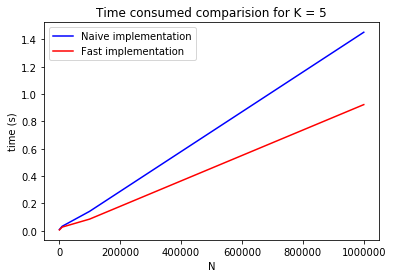

In [177]:
n = [1000,10000,100000,1000000]

naive_time_log = [i for i in naive_time[0]]
fast_time_log = [i for i in fast_time[0]]
plt.plot(n,naive_time_log,color = "b",label ='Naive implementation')
plt.plot(n,fast_time_log,color = 'r',label ='Fast implementation')
plt.legend()
plt.xlabel("N")
plt.ylabel("time (s)")
plt.title("Time consumed comparision for K = 5")
plt.show()

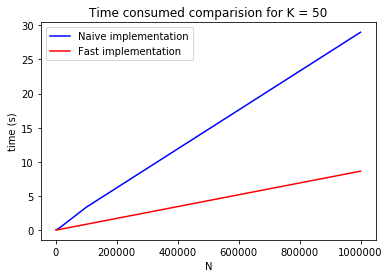

In [176]:
n = [1000,10000,100000,1000000]

naive_time_log = [i for i in naive_time[1]]
fast_time_log = [i for i in fast_time[1]]
plt.plot(n,naive_time_log,color = "b",label ='Naive implementation')
plt.plot(n,fast_time_log,color = 'r',label ='Fast implementation')
plt.legend()
plt.xlabel("N")
plt.ylabel("time (s)")
plt.title("Time consumed comparision for K = 50")
plt.show()